In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
from keras.applications import DenseNet201
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,Conv2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from typing import Iterator, List, Union, Tuple, Any
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Input
import numpy as np

IMAGE_TO_DISPLAY = 3
CLASS_DICT = {"COAD":0,"LUSC":1,"SKCM":2 }
DATA_BATCH_SIZE = 32


In [8]:
def create_generators() : 

  # create an ImageDataGenerator object with TIFF image format
  datagen = ImageDataGenerator(
    #preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True, 
    fill_mode="nearest",
    rescale=1./255, data_format='channels_last', dtype='float32')
  
  validation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,rescale=1./255)

  
    # read TIFF images from a directory
  train_datagenerator = datagen.flow_from_directory(directory="/content/gdrive/MyDrive/comp411project/FinalProject/project/data/train",
                                          target_size=(224, 224),
                                          class_mode='sparse',
                                          color_mode='rgb',
                                          classes = ['TCGA-COAD','TCGA-LUSC','TCGA-SKCM'],
                                          batch_size=DATA_BATCH_SIZE,
                                          save_to_dir=None,
                                          save_prefix='',
                                          save_format='tiff',
                                          follow_links=False,
                                          subset='training',
                                          shuffle=True,
                                          interpolation='nearest')
  # read TIFF images from a directory
  val_datagenerator = datagen.flow_from_directory(directory="/content/gdrive/MyDrive/comp411project/FinalProject/project/data/validation",
                                          target_size=(224, 224),
                                          class_mode='sparse',
                                          color_mode='rgb',
                                          classes = ['TCGA-COAD','TCGA-LUSC','TCGA-SKCM'],
                                          batch_size=DATA_BATCH_SIZE,
                                          save_to_dir=None,
                                          save_prefix='',
                                          save_format='tiff',
                                          follow_links=False,
                                          shuffle=False,
                                          interpolation='nearest')
  
  # read TIFF images from a directory
  test_datagenerator = validation_datagen.flow_from_directory(directory="/content/gdrive/MyDrive/comp411project/FinalProject/project/data/test",
                                          target_size=(224, 224),
                                          class_mode='sparse',
                                          color_mode='rgb',
                                          classes = ['TCGA-COAD','TCGA-LUSC','TCGA-SKCM'],
                                          batch_size=DATA_BATCH_SIZE,
                                          save_to_dir=None,
                                          save_prefix='',
                                          save_format='tiff',
                                          follow_links=False,
                                          shuffle=False,
                                          interpolation='nearest')
  
  print('Training', train_datagenerator)
  print('Validation', val_datagenerator)
  print('Test', test_datagenerator)

  return train_datagenerator, val_datagenerator, test_datagenerator

def display_images(datagenerator, image_number) :

  # create figure
  fig = plt.figure(figsize=(10, 7))
    
  # setting values to rows and column variables
  rows = 2
  columns = 2

  batch_size = 32
  for i in range(1,image_number):
      img, label = datagenerator.next()
      fig.add_subplot(rows, columns, i)
      print(img.shape)   #  (1,256,256,3)
      plt.title(label[0])
      plt.axis('off')
      plt.imshow(img[0])

In [9]:
def generate_age_and_class_values(generator, naming,column) :

  directory= '/content/gdrive/MyDrive/comp411project/FinalProject/project/data_age/' 

  df1=pd.read_csv(directory+"/"+list(CLASS_DICT.keys())[0]+ "_" + naming +".csv")
  df2=pd.read_csv(directory+"/"+list(CLASS_DICT.keys())[1]+ "_" + naming +".csv")
  df3=pd.read_csv(directory+"/"+list(CLASS_DICT.keys())[2]+ "_" + naming +".csv")

  df1['age_normalized'] = (df1['age'] - df1['age'].min()) / (df1['age'].max() - df1['age'].min())
  df2['age_normalized'] = (df2['age'] - df2['age'].min()) / (df2['age'].max() - df2['age'].min())
  df3['age_normalized'] = (df3['age'] - df3['age'].min()) / (df3['age'].max() - df3['age'].min())

  min_age_value = 0
  max_age_value = 0
  
  table = []

  multi_classes = []
  iter = 0
  iter_prob = 0

  for file_name in generator.filenames:
    patient_id = file_name[10:22]
    
    iter = iter + 1
    #print(patient_id , file_name)
    try :
      df_result = df1.loc[df1["patient id"] == patient_id, column].item()
      min_age_value = df1['age'].min()
      max_age_value = df1['age'].max()
      table.append(df_result) 
      multi_classes.append(CLASS_DICT.get(list(CLASS_DICT.keys())[0]))
      continue    
    except :
      try : 
        df_result = df2.loc[df2["patient id"] == patient_id, column].item()
        min_age_value = df2['age'].min()
        max_age_value = df2['age'].max()
        table.append(df_result) 
        multi_classes.append(CLASS_DICT.get(list(CLASS_DICT.keys())[1]))
        continue 
      except:
        try :
          df_result = df3.loc[df3["patient id"] == patient_id, column].item()
          min_age_value = df3['age'].min()
          max_age_value = df3['age'].max()
          table.append(df_result)
          multi_classes.append(CLASS_DICT.get(list(CLASS_DICT.keys())[2]))
          continue 
        except:
          iter_prob = iter_prob + 1
          continue
      continue
  #return np.array(table, dtype=float), np.array(to_categorical(multi_classes, num_classes=3))
  return np.array(table, dtype=float), np.array(multi_classes, dtype=int), min_age_value, max_age_value


Found 689 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 148 images belonging to 3 classes.
Training <keras.preprocessing.image.DirectoryIterator object at 0x7f891fbdeca0>
Validation <keras.preprocessing.image.DirectoryIterator object at 0x7f898d46fd30>
Test <keras.preprocessing.image.DirectoryIterator object at 0x7f898e4df6a0>
(32, 224, 224, 3)
(32, 224, 224, 3)


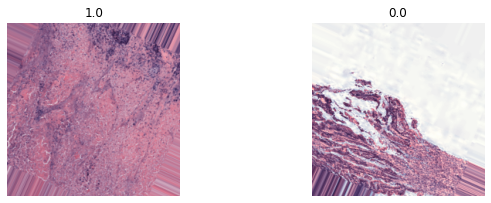

In [10]:
train_generator, val_generator, test_generator = create_generators()

#obtain training and validation X
X_train=np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])

X_val=np.concatenate([val_generator.next()[0] for i in range(val_generator.__len__())])

X_test = np.concatenate([test_generator.next()[0] for i in range(test_generator.__len__())])

display_images(train_generator, IMAGE_TO_DISPLAY)



In [11]:
 # create age layer
train_age_inputs, train_class_inputs,train_min_age, train_max_age = generate_age_and_class_values(train_generator, "train", "age_normalized")
val_age_inputs, val_class_inputs,val_min_age, val_max_age = generate_age_and_class_values(val_generator, "validation", "age_normalized")
test_age_inputs, test_class_inputs,test_min_age, test_max_age = generate_age_and_class_values(test_generator, "test", "age_normalized")

print(len(train_age_inputs),len(train_class_inputs))
print(len(val_age_inputs),len(val_class_inputs))
print(len(test_age_inputs),len(test_class_inputs))
print(train_min_age, train_max_age, val_min_age, val_max_age, test_min_age, test_max_age)


689 689
150 150
148 148
18 87 47 52 37 70


In [82]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
adam_optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)


learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)


adam_fine = Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [83]:
from tensorflow.keras.applications import ResNet152V2
pre_trained_model = ResNet152V2(include_top = False,
                             pooling = 'avg',
                            input_shape = (224,224,3),
                            weights = 'imagenet')

In [84]:
# freeze all layers in the base model
pre_trained_model.trainable = False

# un-freeze the BatchNorm layers
for layer in pre_trained_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

In [85]:
last_output = pre_trained_model.output

In [86]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(3, activation = 'softmax')(x)

In [87]:
model = tf.keras.Model(pre_trained_model.input, x)

In [88]:
model.compile(optimizer=adam_fine, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['acc'])

In [89]:
history = model.fit(train_generator,
                              epochs=20,
                              verbose=1,
                              validation_data=val_generator,
                             callbacks = [learning_rate_reduction])

Epoch 1/20
22/22 [==============================] - 29s 795ms/step - loss: 1.2791 - acc: 0.4035 - val_loss: 1.2912 - val_acc: 0.3933 - lr: 3.0000e-04
Epoch 2/20
22/22 [==============================] - 14s 635ms/step - loss: 0.9802 - acc: 0.5617 - val_loss: 1.0648 - val_acc: 0.4867 - lr: 3.0000e-04
Epoch 3/20
22/22 [==============================] - 14s 635ms/step - loss: 0.8846 - acc: 0.6038 - val_loss: 1.0010 - val_acc: 0.5267 - lr: 3.0000e-04
Epoch 4/20
22/22 [==============================] - 14s 631ms/step - loss: 0.7833 - acc: 0.6560 - val_loss: 1.0120 - val_acc: 0.5400 - lr: 3.0000e-04
Epoch 5/20
22/22 [==============================] - 14s 628ms/step - loss: 0.7178 - acc: 0.7025 - val_loss: 1.0483 - val_acc: 0.5533 - lr: 3.0000e-04
Epoch 6/20
22/22 [==============================] - 14s 625ms/step - loss: 0.7345 - acc: 0.6938 - val_loss: 0.9907 - val_acc: 0.5400 - lr: 3.0000e-04
Epoch 7/20
22/22 [==============================] - 14s 626ms/step - loss: 0.7258 - acc: 0.6952 - va

In [92]:
Y_class_pred = model.predict(X_test, verbose=1)

Y_class_pred = Y_class_pred.argmax(axis=-1)

5/5 [==============================] - 4s 441ms/step


In [93]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print("F1 Score: ", f1_score(test_class_inputs, Y_class_pred, average="macro"))
print("Precision Score: ", precision_score(test_class_inputs, Y_class_pred, average="macro"))
print("Recall Score: ", recall_score(test_class_inputs, Y_class_pred, average="macro")) 

print(classification_report(test_class_inputs, Y_class_pred))

F1 Score:  0.43869449851503695
Precision Score:  0.5498022294138799
Recall Score:  0.49333333333333335
              precision    recall  f1-score   support

           0       0.43      0.88      0.58        50
           1       0.56      0.10      0.17        50
           2       0.67      0.50      0.57        48

    accuracy                           0.49       148
   macro avg       0.55      0.49      0.44       148
weighted avg       0.55      0.49      0.44       148



dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


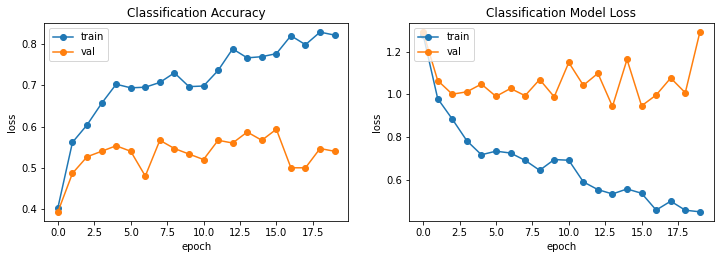

In [109]:
print(history)
print(history.history.keys())
# summarize history for accuracy

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['acc'],'-o')
plt.plot(history.history['val_acc'],'-o')
plt.title('Classification Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Plt1.png')

# summarize history for loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'],'-o')
plt.plot(history.history['val_loss'],'-o')
plt.title('Classification Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('Plt2.png')
plt.show()

In [95]:
loss, accuracy = model.evaluate(x=X_test,
                                y=test_class_inputs,
                                batch_size=60)

print()
print(f'loss: {loss}')
print(f'classification_loss: {loss}')
print(f'classification_output_accuracy: {accuracy}')

3/3 [==============================] - 6s 743ms/step - loss: 1.3509 - acc: 0.4932

loss: 1.3509403467178345
classification_loss: 1.3509403467178345
classification_output_accuracy: 0.4932432472705841


In [ ]:
from keras.utils.vis_utils import plot_model
#Create the generators

plot_model(model,"Resnet.jpg",show_shapes="True")

Callback Implementations

In [98]:
from random import sample
# Function that will pick a random set of images from the dataset
def get_random_images(num, X,y,y_pred,nseed=1):
    
    boundary = list(range(0, len(y)))
    
    values = sample(boundary, num)
    
    images = []
    labels = []
    classes = []
    preds = []
    
    for v in values:
      images.append(X[v])
      classes.append(y[v])
      if y[v] == 0 :
        labels.append("COAD")
      elif y[v] == 1 :
        labels.append("LUSC")
      else :
        labels.append("SKCM")
      preds.append(y_pred[v])

    return images, labels, classes, preds

In [99]:
def find_corresponding_label(y_value):
  
  if y_value == 0 :
    return "COAD"
  elif y_value == 1 :
    return "LUSC"
  else :
    return ("SKCM")
  

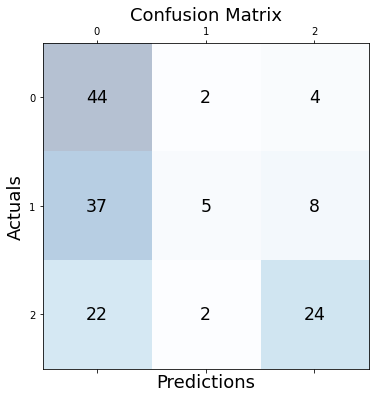

In [107]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_true=test_class_inputs, y_pred=Y_class_pred )
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Confusion Matrix

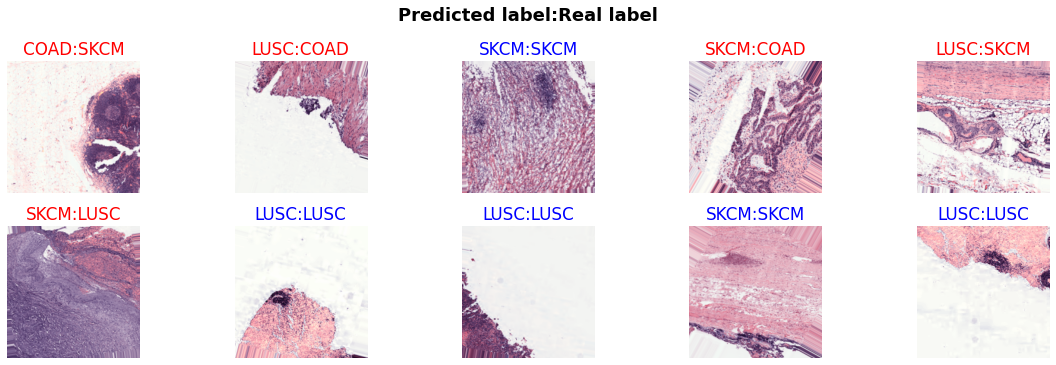

In [44]:
plt.rcParams.update({'font.size': 14})
images, labels, classes,preds = get_random_images(10, X_test,test_class_inputs,Y_class_pred)

fig = plt.figure(figsize=(16,15)) 
st = fig.suptitle("Predicted label:Real label", fontsize=18, 
                  fontweight="bold")

for ii in range(len(images)):
    image = images[ii]
    #image = to_np(images[ii])

    sub = fig.add_subplot(6, 5, ii+1)
    res = (classes[ii] == preds[ii])
    
    pred_label = find_corresponding_label(preds[ii])
    X_label = find_corresponding_label(classes)
    
    sub.set_title(pred_label + ":" + labels[ii] ,
                  fontdict = {"color": "blue" if res == True else "red"})
    
    plt.axis('off')
    plt.imshow(image)

fig.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.9)
plt.show()

In [45]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print("F1 Score: ", f1_score(test_class_inputs, Y_class_pred, average="macro"))
print("Precision Score: ", precision_score(test_class_inputs, Y_class_pred, average="macro"))
print("Recall Score: ", recall_score(test_class_inputs, Y_class_pred, average="macro")) 

print(classification_report(test_class_inputs, Y_class_pred))


F1 Score:  0.2647967116052222
Precision Score:  0.28703241203241203
Recall Score:  0.2891666666666667
              precision    recall  f1-score   support

           0       0.29      0.14      0.19        50
           1       0.30      0.54      0.38        50
           2       0.27      0.19      0.22        48

    accuracy                           0.29       148
   macro avg       0.29      0.29      0.26       148
weighted avg       0.29      0.29      0.27       148



In [52]:
loss, accuracy = full_model.evaluate(x=X_test,
                                y=test_class_inputs,
                                batch_size=60)

print()
print(f'loss: {loss}')
print(f'classification_loss: {loss}')
print(f'classification_output_accuracy: {accuracy}')


3/3 [==============================] - 1s 285ms/step - loss: 1.4292 - acc: 0.3176

loss: 1.4292291402816772
classification_loss: 1.4292291402816772
classification_output_accuracy: 0.3175675570964813


Visualizing the Data

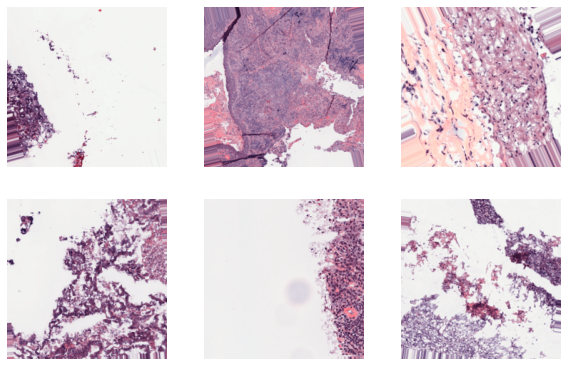

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for i in range(6):
    images, _ = next(train_generator)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[0])
    plt.axis("off")
    

Augmentation Effects

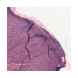

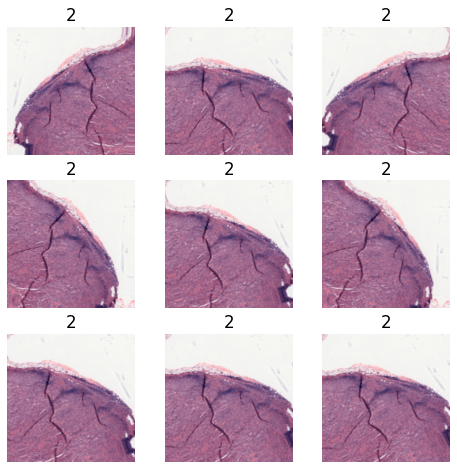

In [ ]:
data_augmentation_horizontal = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)
import numpy as np

for i in range(1):
    images, labels = next(train_generator)
    ax = plt.subplot(3, 3, 1)
    plt.imshow(images[0])
    plt.axis("off")

    plt.figure(figsize=(8, 8))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation_horizontal(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy())
        plt.title(int(labels[0]))
        plt.axis("off")



In [ ]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

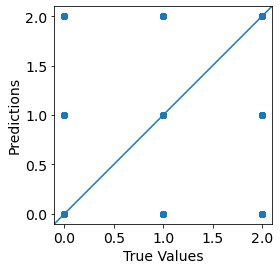

In [ ]:
plot_diff(test_class_inputs, Y_class_pred)